### Preprocessing

For local run, we cannot afford running with full data. We will sample the data randomly (using hash) to about 200~300 instances. It takes about 15 minutes.

In [1]:
import mltoolbox.image.classification as model
from google.datalab.ml import *

worker_dir = '/content/datalab/tmp/coast'
preprocessed_dir = worker_dir + '/coast300'
model_dir = worker_dir + '/model300'

In [2]:
train_set = BigQueryDataSet('SELECT image_url, label FROM coast.train WHERE rand() < 0.04')
model.preprocess(train_set, preprocessed_dir)

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:136: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)


completed


### Train

To get help of a certain method, run 'mymethod??' and on the right side you will see the method signature. For example, run 'local_train??'.

In [3]:
import logging
logging.getLogger().setLevel(logging.INFO)
model.train(preprocessed_dir, 30, 1000, model_dir)
logging.getLogger().setLevel(logging.WARNING)

INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 0
INFO:root:Train [master/0], step 1 (0.077 sec) 13.0 global steps/s, 13.0 local steps/s
INFO:root:Eval, step 1:
- on train set loss: 2.510, accuracy: 0.383
-- on eval set loss: 2.549, accuracy: 0.367
INFO:root:Eval, step 1000:
- on train set loss: 0.002, accuracy: 1.000
-- on eval set loss: 2.806, accuracy: 0.367
INFO:root:Exporting prediction graph to /content/datalab/tmp/coast/model300/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/datalab/tmp/coast/model300/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/datalab/tmp/coast/model300/model/saved_model.pb


completed


You can start hosted Tensorboard to check events.

In [4]:
tb_id = TensorBoard.start(model_dir)

TensorBoard was started successfully with pid 29461. Click here to access it.

### Evaluation

Our model was trained with a small subset of the data so accuracy is not very high.

First, we can check the TF summary events from training.

In [5]:
summary = Summary(model_dir)
summary.list_events()

{u'accuracy': {'/content/datalab/tmp/coast/model300/eval_set',
  '/content/datalab/tmp/coast/model300/train_set'},
 u'batch/fraction_of_450_full': {'/content/datalab/tmp/coast/model300/eval_set',
  '/content/datalab/tmp/coast/model300/train_set'},
 u'global_step/sec': {'/content/datalab/tmp/coast/model300/train'},
 u'input_producer/fraction_of_32_full': {'/content/datalab/tmp/coast/model300/eval_set',
  '/content/datalab/tmp/coast/model300/train_set'},
 u'loss': {'/content/datalab/tmp/coast/model300/eval_set',
  '/content/datalab/tmp/coast/model300/train_set'}}

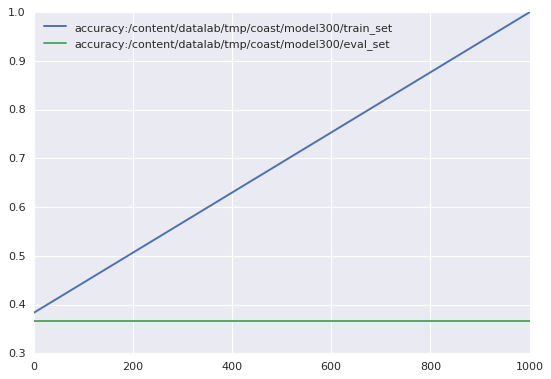

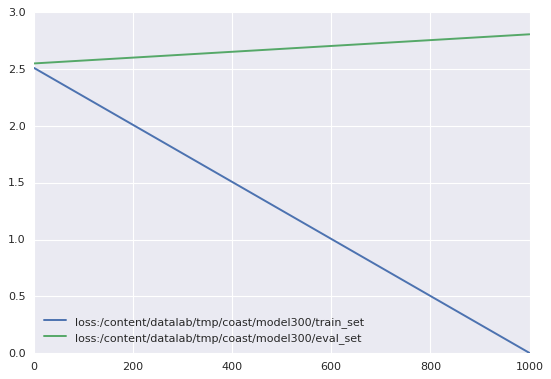

In [6]:
summary.plot('accuracy')
summary.plot('loss')

We will do more evaluation with more data using batch prediction.

### Prediction

Instant prediction:

In [7]:
# gs://tamucc_coastline/esi_images/IMG_2849_SecDE_Spr12.jpg,3B
# gs://tamucc_coastline/esi_images/IMG_0047_SecBC_Spr12.jpg,10A
# gs://tamucc_coastline/esi_images/IMG_0617_SecBC_Spr12.jpg,7
# gs://tamucc_coastline/esi_images/IMG_2034_SecEGH_Sum12_Pt2.jpg,10A
images = [
  'gs://tamucc_coastline/esi_images/IMG_2849_SecDE_Spr12.jpg',
  'gs://tamucc_coastline/esi_images/IMG_0047_SecBC_Spr12.jpg',
  'gs://tamucc_coastline/esi_images/IMG_0617_SecBC_Spr12.jpg',
  'gs://tamucc_coastline/esi_images/IMG_2034_SecEGH_Sum12_Pt2.jpg'
]
# Set show_image to True to see the images
model.predict(model_dir, images, show_image=False)

Predicting...


,image_url,label,score
0,gs://tamucc_coastline/esi_images/IMG_2849_SecD...,10A,0.965391
1,gs://tamucc_coastline/esi_images/IMG_0047_SecB...,10A,0.964431
2,gs://tamucc_coastline/esi_images/IMG_0617_SecB...,7,0.996017
3,gs://tamucc_coastline/esi_images/IMG_2034_SecE...,10A,0.954304


Batch prediction. Note that we sample eval data so we use about 200 instances.

In [8]:
eval_set = BigQueryDataSet('select * from coast.eval WHERE rand()<0.1')
model.batch_predict(eval_set, model_dir, output_bq_table='coast.eval200tinymodel')

completed


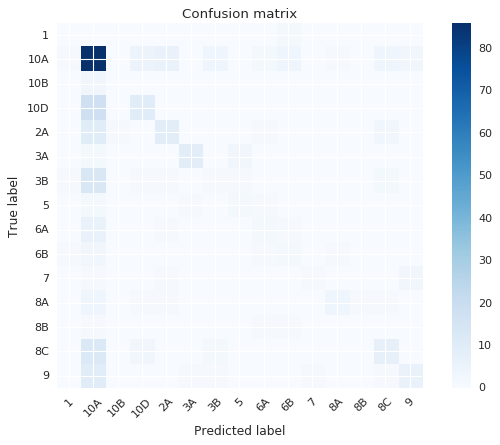

In [9]:
ConfusionMatrix.from_bigquery('select * from coast.eval200tinymodel').plot()

Compute accuracy per label.

In [10]:
%%bq query --name accuracy
SELECT
  target,
  SUM(CASE WHEN target=predicted THEN 1 ELSE 0 END) as correct,
  COUNT(*) as total,
  SUM(CASE WHEN target=predicted THEN 1 ELSE 0 END)/COUNT(*) as accuracy
FROM
  coast.eval200tinymodel
GROUP BY
  target

In [11]:
accuracy.execute().result()

target,correct,total,accuracy
10B,0,3,0.0
1,0,2,0.0
8B,0,3,0.0
3B,1,20,0.05
7,1,6,0.166666666667
5,2,6,0.333333333333
6B,2,8,0.25
6A,2,10,0.2
8A,4,12,0.333333333333
9,6,20,0.3


You can view the results using Feature-Slice-View. This time do logloss.

In [12]:
%%bq query --name logloss

SELECT feature, AVG(-logloss) as logloss, COUNT(*) as count FROM
(
  SELECT feature, CASE WHEN correct=1 THEN LOG(prob) ELSE LOG(1-prob) END as logloss
  FROM
  (
    SELECT
    target as feature, 
    CASE WHEN target=predicted THEN 1 ELSE 0 END as correct,
    target_prob as prob
    FROM coast.eval200tinymodel
  )
)
GROUP BY feature

In [13]:
FeatureSliceView().plot(logloss)

## Clean up

In [14]:
import shutil
import google.datalab.bigquery as bq

TensorBoard.stop(tb_id)
bq.Table('coast.eval200tinymodel').delete()
shutil.rmtree(worker_dir)